<a href="https://colab.research.google.com/github/marcolussetti/opendotadump-tools/blob/master/analysis/winratio/GraphWinRatios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Hero Ratios
This notebook will produce graphs of the heroes' win ratio on a per-day basis.

## Processing

### Constants for configuration

In [0]:
CSV_INPUT_FILE = "https://raw.githubusercontent.com/marcolussetti/opendotadump-tools/master/data/heroes_winratio_csvs/temp_win_ratios.csv"
OPENDOTA_API_HEROES_ENDPOINT = "https://api.opendota.com/api/heroes/"

### Imports & Configuration

In [2]:
# If plotnine is not installed:
!pip install plotnine

# If using on google colab, might need to update statsmodels version
!pip install statsmodels -U

# If not installed
!pip install requests

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [0]:
import pandas as pd
import requests
from plotnine import *
from scipy.spatial import distance
from datetime import datetime, timedelta
import numpy as np

In [0]:
%matplotlib inline

### Import data

In [0]:
# Load input csv
df = pd.read_csv(CSV_INPUT_FILE, index_col=0)

In [0]:
# Load heroes data
heroes_json = requests.get("http://api.opendota.com/api/heroes/").json()
heroes = {hero["localized_name"]: hero for hero in heroes_json}

### Examine the data

#### Structure of dataset

In [14]:
df.head()

,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,Morphling,...,Elder Titan,Legion Commander,Techies,Ember Spirit,Earth Spirit,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
2011-11-23,0.476190,0.333333,NaN,0.428571,0.500000,0.411765,0.428571,1.000000,0.629630,0.444444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-24,0.500000,0.100000,NaN,0.600000,0.411765,0.333333,0.380952,0.333333,0.500000,0.222222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-25,0.439024,0.294118,NaN,0.250000,0.500000,0.538462,0.476190,0.692308,0.500000,0.562500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-26,0.521739,0.200000,NaN,0.272727,0.666667,0.461538,0.733333,0.642857,0.545455,0.545455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-27,0.622222,0.363636,NaN,0.480000,0.473684,0.571429,0.560000,0.666667,0.318182,0.583333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df.describe()

,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,Morphling,...,Elder Titan,Legion Commander,Techies,Ember Spirit,Earth Spirit,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
count,1567.000000,1557.000000,1457.000000,1565.000000,1567.000000,1564.000000,1567.000000,1564.000000,1562.000000,1560.000000,...,1023.000000,819.000000,541.000000,843.000000,839.000000,757.000000,765.000000,464.000000,381.000000,73.000000
mean,0.457263,0.479824,0.450245,0.510080,0.527667,0.520990,0.504445,0.498430,0.518467,0.436807,...,0.509403,0.469061,0.495593,0.452763,0.447007,0.473230,0.518632,0.420247,0.496429,0.455543
std,0.067673,0.078118,0.067277,0.075986,0.073173,0.081339,0.061791,0.061456,0.057814,0.072603,...,0.083938,0.072181,0.100917,0.066864,0.090994,0.090010,0.090592,0.118314,0.116182,0.242106
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.429649,0.455999,0.423077,0.480000,0.505698,0.502390,0.482451,0.477661,0.500000,0.407160,...,0.476834,0.450455,0.466796,0.435808,0.413215,0.440000,0.496774,0.379961,0.484155,0.387395
50%,0.456140,0.488235,0.450402,0.516129,0.533563,0.525401,0.511111,0.501035,0.521366,0.435484,...,0.510638,0.473684,0.500000,0.456091,0.458559,0.475728,0.517544,0.417714,0.505051,0.437500
75%,0.482484,0.515833,0.477273,0.542636,0.550840,0.551020,0.532464,0.522251,0.539812,0.466667,...,0.541080,0.492521,0.521406,0.473672,0.490521,0.513661,0.539773,0.442725,0.519565,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Overall heroes  metrics

In [21]:
heroes_highest_winratio = df.mean().sort_values(ascending=False)[:10]  # Average of win ratio
heroes_highest_winratio

Abaddon              0.576774
Ursa                 0.560926
Zeus                 0.555513
Omniknight           0.552933
Lich                 0.550921
Centaur Warrunner    0.548295
Warlock              0.542463
Spectre              0.542249
Necrophos            0.538231
Treant Protector     0.534694
dtype: float64

In [18]:
# Heroes with the most variation
heroes_winratio_std = df.std().sort_values(ascending=False)[:10]  # Standard deviation of pick frequency
heroes_winratio_std

Arc Warden          0.242106
Oracle              0.118314
Winter Wyvern       0.116182
Techies             0.100917
Chen                0.094570
Earth Spirit        0.090994
Phoenix             0.090592
Terrorblade         0.090010
Batrider            0.089510
Treant Protector    0.087919
dtype: float64

In [38]:
# Heroes with highest least variation
heroes_lowest_winratio = df.mean().sort_values(ascending=True)[:10]  # Average of win ratio
heroes_lowest_winratio

Oracle          0.420247
Morphling       0.436807
Alchemist       0.438293
Broodmother     0.442759
Io              0.443031
Shadow Demon    0.444254
Earth Spirit    0.447007
Puck            0.449288
Enchantress     0.449553
Bane            0.450245
dtype: float64

#### Exploratory graphing

In [0]:
df_with_date_col = df.copy(deep=True)
df_with_date_col = df_with_date_col.reset_index(level=0)
df_with_date_col.columns = ["Date", *df_with_date_col.columns[1:]]

In [24]:
df_with_date_col.head()

,Date,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,...,Elder Titan,Legion Commander,Techies,Ember Spirit,Earth Spirit,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,2011-11-23,0.476190,0.333333,NaN,0.428571,0.500000,0.411765,0.428571,1.000000,0.629630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-11-24,0.500000,0.100000,NaN,0.600000,0.411765,0.333333,0.380952,0.333333,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-11-25,0.439024,0.294118,NaN,0.250000,0.500000,0.538462,0.476190,0.692308,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-11-26,0.521739,0.200000,NaN,0.272727,0.666667,0.461538,0.733333,0.642857,0.545455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-11-27,0.622222,0.363636,NaN,0.480000,0.473684,0.571429,0.560000,0.666667,0.318182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotni

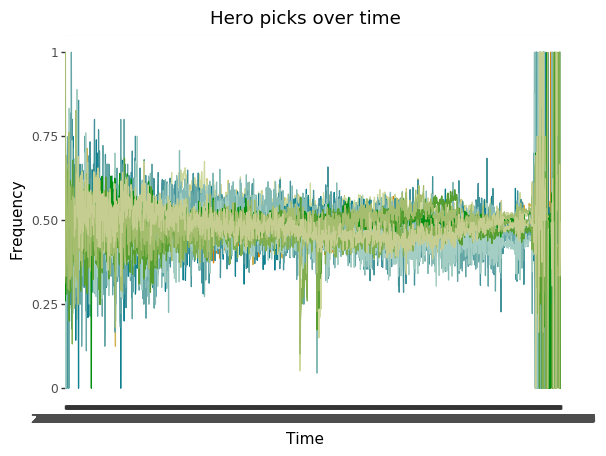

<ggplot: (-9223363302952155960)>

In [25]:
basic_plot = (ggplot(df_with_date_col, aes())
 # Highest variance
 +geom_line(aes('Date', 'Phantom Assassin', group=1), color='#de7f05')
 +geom_line(aes('Date', 'Legion Commander', group=1), color='#d59a2b')
 +geom_line(aes('Date', 'Invoker', group=1), color='#cfb24f')
 +geom_line(aes('Date', 'Slark', group=1), color='#cbc675')
 +geom_line(aes('Date', 'Drow Ranger', group=1), color='#ccd89c')
 # Lowest variance
 +geom_line(aes('Date', 'Pugna', group=1), color='#0f808f')
 +geom_line(aes('Date', 'Chen', group=1), color='#42939a')
 +geom_line(aes('Date', 'Batrider', group=1), color='#65a7a6')
 +geom_line(aes('Date', 'Visage', group=1), color='#85bbb4')
 +geom_line(aes('Date', 'Enchantress', group=1), color='#a4cec3')
 # Highest popularity (skipping already used ones)
 +geom_line(aes('Date', 'Pudge', group=1), color='#038f0f')
 +geom_line(aes('Date', 'Sniper', group=1), color='#569e30')
 +geom_line(aes('Date', 'Windranger', group=1), color='#81ae4e')
 +geom_line(aes('Date', 'Juggernaut', group=1), color='#a5bd6e')
 +geom_line(aes('Date', 'Bounty Hunter', group=1), color='#c5cd91')
 #Config
 +ggtitle("Hero picks over time")
 +ylab("Frequency")
 +xlab("Time")
)
basic_plot

#### Reformat data for "easy" graphing

In [0]:
df_expl_graph = df.copy(deep=True)
# Condense values
df_expl_graph = df_expl_graph.stack()
df_expl_graph = df_expl_graph.reset_index()

df_expl_graph.columns = ["Day", "Hero", "Winratio"]

df_expl_graph["Day"] = df_expl_graph["Day"].apply(pd.to_datetime)

df_expl_graph["Week"] = df_expl_graph["Day"].apply(lambda date: "{}-{}".format(date.year,date.week))
df_expl_graph["Month"] = df_expl_graph["Day"].apply(lambda date: "{}-{}".format(date.year,date.month))
df_expl_graph["Year"] = df_expl_graph["Day"].apply(lambda date: date.year)


In [28]:
df_expl_graph.head()

,Day,Hero,Winratio,Week,Month,Year
0,2011-11-23,Anti-Mage,0.476190,2011-47,2011-11,2011
1,2011-11-23,Axe,0.333333,2011-47,2011-11,2011
2,2011-11-23,Bloodseeker,0.428571,2011-47,2011-11,2011
3,2011-11-23,Crystal Maiden,0.500000,2011-47,2011-11,2011
4,2011-11-23,Drow Ranger,0.411765,2011-47,2011-11,2011


In [0]:
df_highest_winratio = df_expl_graph[df_expl_graph["Hero"].isin(heroes_highest_winratio.keys())]
df_lowest_winratio = df_expl_graph[df_expl_graph["Hero"].isin(heroes_lowest_winratio.keys())]
df_winratio_std = df_expl_graph[df_expl_graph["Hero"].isin(heroes_winratio_std.keys())]

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


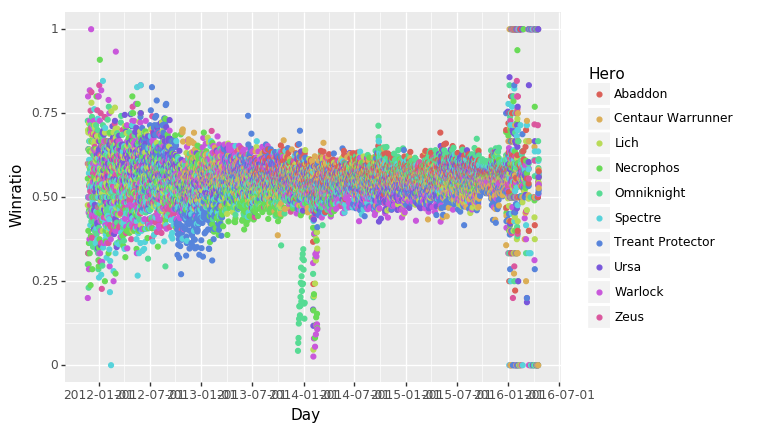

<ggplot: (-9223363302952012242)>

In [32]:
day_plot = (ggplot(df_highest_winratio, aes(x="Day", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
day_plot

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


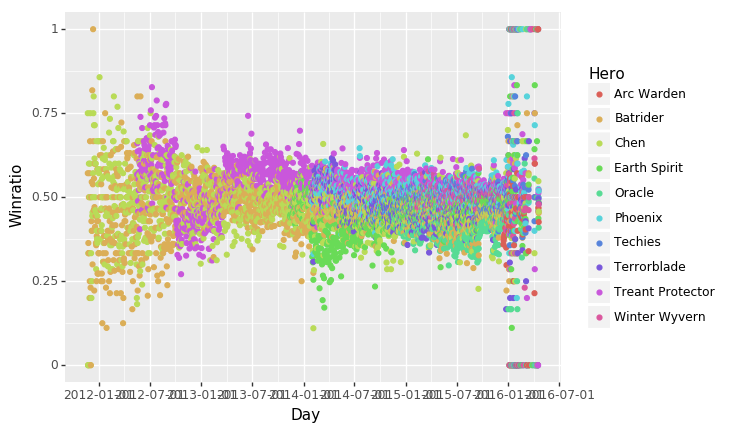

<ggplot: (8733898063073)>

In [35]:
day_plot_std = (ggplot(df_winratio_std, aes(x="Day", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
day_plot_std

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


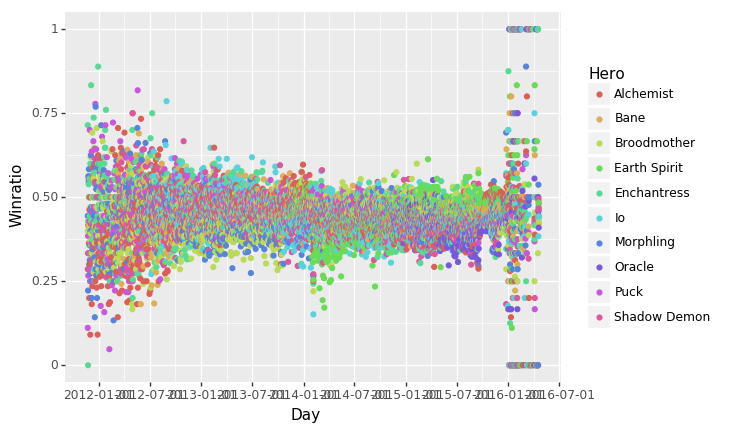

<ggplot: (-9223363302953651389)>

In [40]:
day_plot_lowest = (ggplot(df_lowest_winratio, aes(x="Day", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
day_plot_lowest

In [41]:
day_plot.save("highest_winratio_day_plot.png", width=40, height=32, dpi=300, limitsize=False)
day_plot_lowest.save("lowest_winratio_day_plot.png", width=40, height=32, dpi=300, limitsize=False)
day_plot_std.save("std_winratio_day_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: highest_winratio_day_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: lowest_winratio_day_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


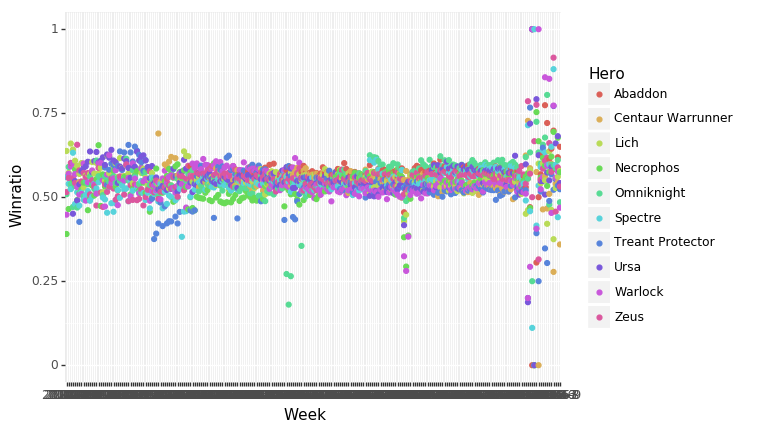

<ggplot: (-9223363302952933660)>

In [42]:
week_plot = (ggplot(df_highest_winratio.groupby(["Week", "Hero"]).mean().reset_index(), aes(x="Week", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
week_plot

In [0]:
week_plot.save("highest_winratio_week_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: most_popular_week_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


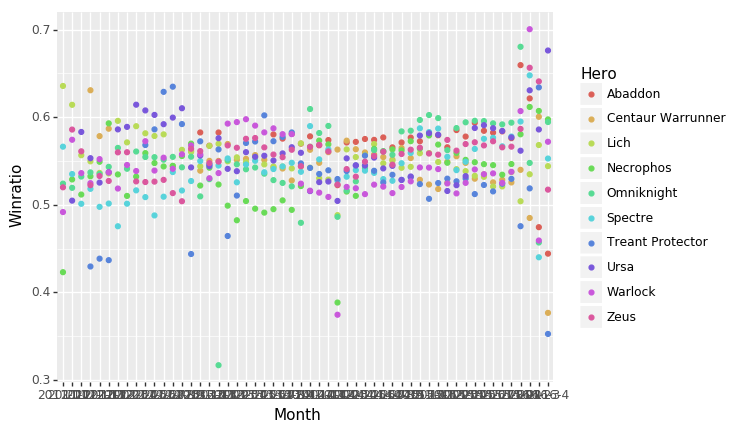

<ggplot: (8733901845831)>

In [43]:
month_plot = (ggplot(df_highest_winratio.groupby(["Month", "Hero"]).mean().reset_index(), aes(x="Month", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
month_plot

In [0]:
month_plot.save("highest_winratio_month_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: most_popular_month_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


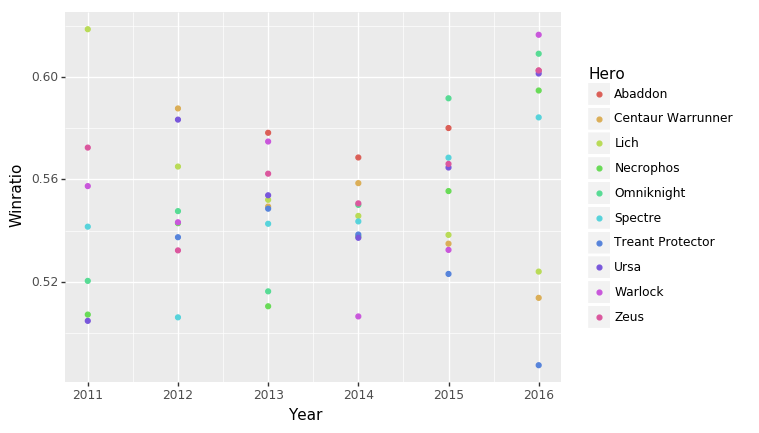

<ggplot: (-9223363302953107333)>

In [44]:
year_plot = (ggplot(df_highest_winratio.groupby(["Year", "Hero"]).mean().reset_index(), aes(x="Year", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
year_plot

In [0]:
year_plot.save("highest_winratio_year_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: most_popular_year_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


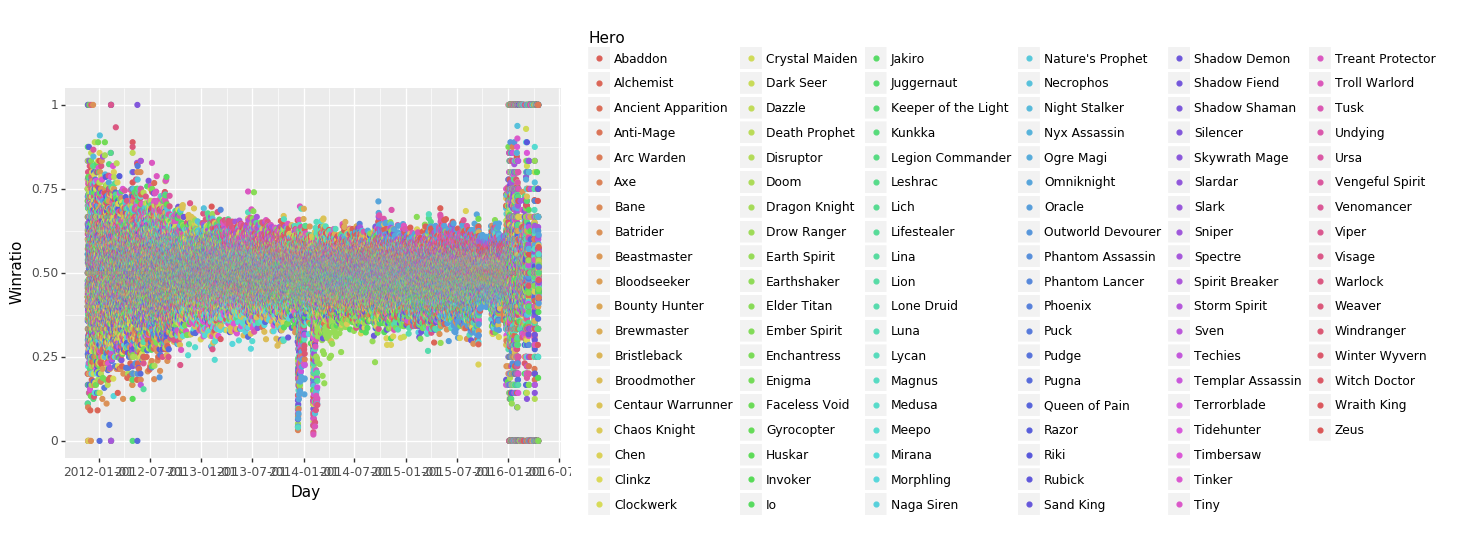

<ggplot: (-9223363302953205202)>

In [55]:
all_day_plot = (ggplot(df_expl_graph, aes(x="Day", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
all_day_plot

In [46]:
all_day_plot.save("winratio_all_day_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: winratio_all_day_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


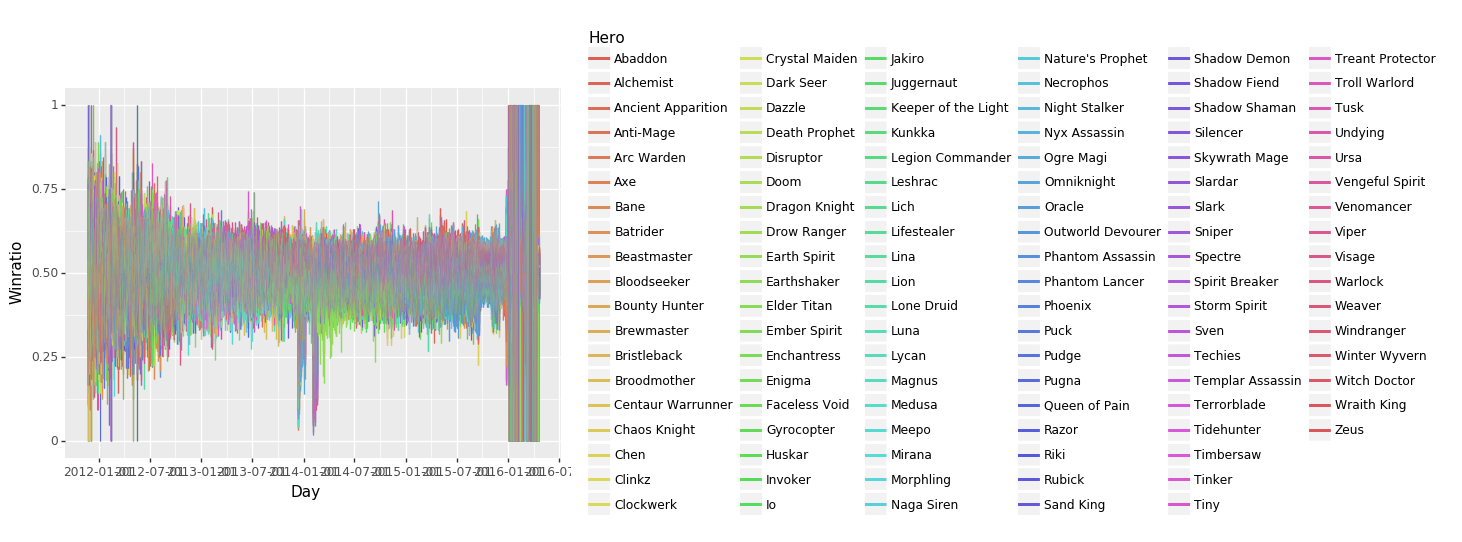

<ggplot: (8733895109829)>

In [54]:
all_day_line_plot = (ggplot(df_expl_graph, aes(x="Day", y="Winratio", color="Hero", group=1))
              +geom_line()
             )
all_day_line_plot

/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


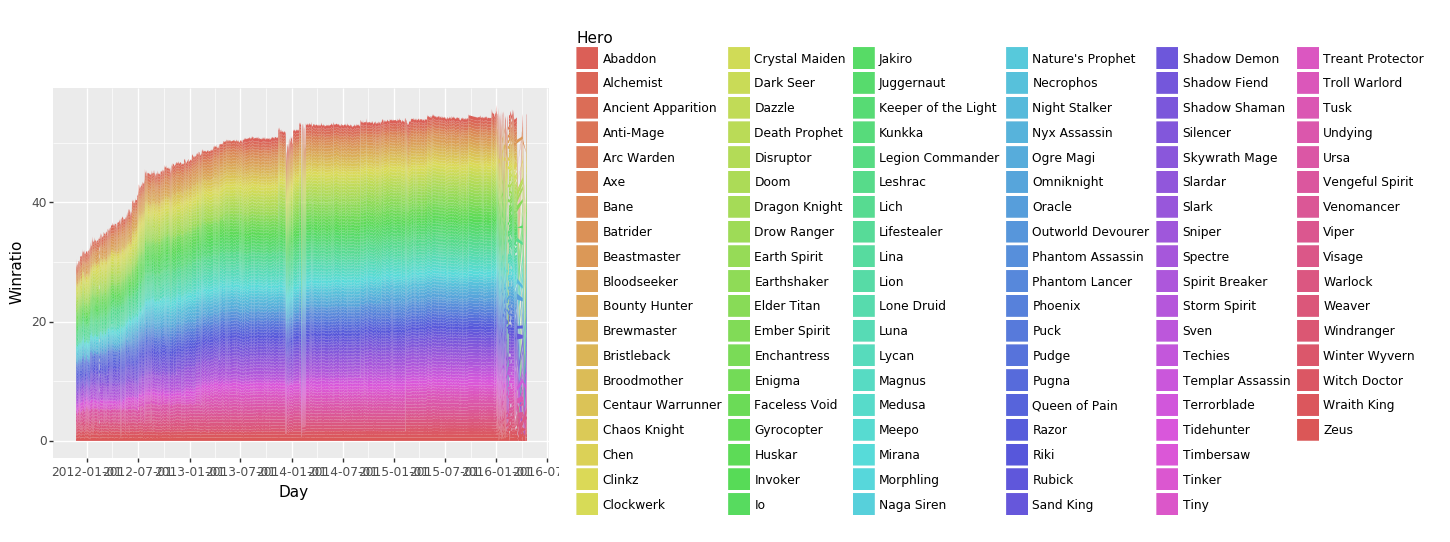

<ggplot: (8733895207870)>

In [47]:
all_day_stacked_plot = (ggplot(df_expl_graph, aes(x="Day", y="Winratio"))
              +geom_area(aes(fill="Hero"))
             )
all_day_stacked_plot

In [48]:
all_day_stacked_plot.save("winratio_all_day_stacked_plot.png", width=44, height=12, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 44 x 12 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: winratio_all_day_stacked_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


#### Detect changes over time

In [0]:
def previous_distribution_vector(df, date_start, date_end, average_function="mean"):
  df_filtered = df[(df["Day"] >= date_start) & (df["Day"] < date_end)]
  
  if average_function == "median":
    result = df_filtered.groupby(["Hero"]).median()[["Winratio"]]
  else:
    result = df_filtered.groupby(["Hero"]).mean()[["Winratio"]]
  
  return result.to_dict()["Winratio"]

In [0]:
def compute_distance(day, previous_period_average, distance_function=distance.euclidean):
  previous = [value for key, value 
              in sorted(previous_period_average.items(), key=lambda x: x[0]) if key in day.keys()]
  current = [value for key, value 
              in sorted(day.items(), key=lambda x: x[0]) if key in previous_period_average.keys()]
  assert len(previous) == len(current), "Incorrect length: previous-> {}, current-> {}".format(len(previous), len(current))
  
  return distance_function(previous, current)
  

In [0]:
def day_difference(df, day, distance_function=distance.euclidean, length=14, average_function="mean"):
  # Extract vector for day
  day_picks = {record["Hero"]: record["Winratio"] for record 
               in df[df["Day"] == day][["Hero", "Winratio"]].to_dict('records')
              }
  previous_picks = previous_distribution_vector(df, datetime.strptime(day, '%Y-%m-%d') - timedelta(days=length), day, average_function)
  
  return compute_distance(day_picks, previous_picks, distance_function)

In [0]:
def all_days_difference(df, distance_function=distance.euclidean, length=14, average_function="mean"):
  all_days = [str(d) for d in sorted(set(date.date() for key, date in df["Day"].to_dict().items()))[1:]]
  
  return {day: day_difference(
      df, day, distance_function=distance.euclidean, 
      length=14, average_function="mean") 
   for day in all_days}

In [0]:
# Try to graph differences for top 10 champions by win ratio

high_winratio_differences_by_day = high_winratio_days_difference(df_highest_winratio).items()
sorted_high_winratio_differences_by_day = sorted(differences_by_day, key=lambda x: x[1], reverse=True)
df_high_winratio_differences_by_day = pd.DataFrame(high_winratio_differences_by_day)
df_high_winratio_differences_by_day.columns = ["Day", "Difference"]
df_high_winratio_differences_by_day.head()

/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


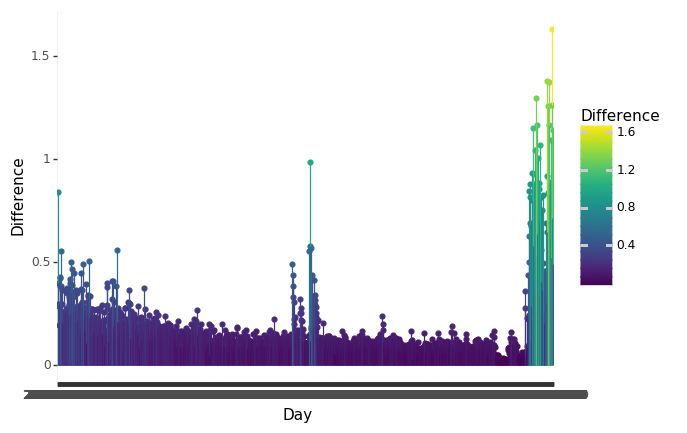

<ggplot: (8733895190525)>

In [59]:
high_winratio_differences_plot = (
    ggplot(df_high_winratio_differences_by_day, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

high_winratio_differences_plot

In [0]:
high_winratio_differences_plot.save("high_winratio_differences_plot.png", width=44, height=5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 2 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: differences_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


In [61]:
# Try to graph differences for top 10 champions by std
high_std_differences_by_day = all_days_difference(df_winratio_std).items()
sorted_std_differences_by_day = sorted(differences_by_day, key=lambda x: x[1], reverse=True)
df_high_std_differences_by_day = pd.DataFrame(high_std_differences_by_day)
df_high_std_differences_by_day.columns = ["Day", "Difference"]
df_high_std_differences_by_day.head()

,Day,Difference
0,2011-11-24,0.942884
1,2011-11-25,0.088363
2,2011-11-26,0.361759
3,2011-11-27,0.376568
4,2011-11-28,0.337281


/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


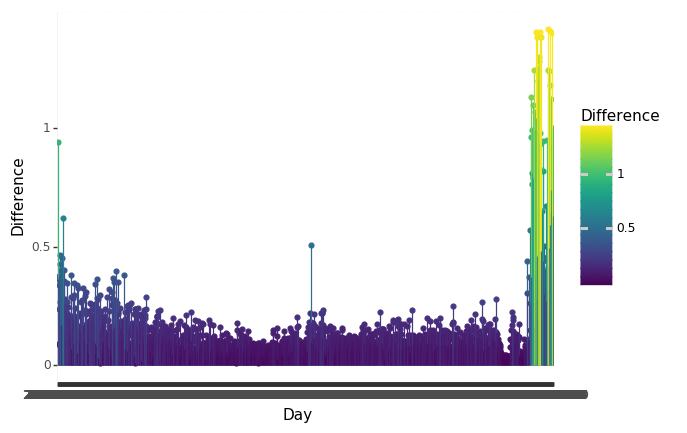

<ggplot: (8733895237608)>

In [62]:
high_std_differences_plot = (
    ggplot(df_high_std_differences_by_day, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

high_std_differences_plot

In [63]:
# Try to graph differences for all heroes

all_differences_by_day = all_days_difference(df_expl_graph).items()
sorted_all_differences_by_day = sorted(differences_by_day, key=lambda x: x[1], reverse=True)
df_all_differences_by_day = pd.DataFrame(all_differences_by_day)
df_all_differences_by_day.columns = ["Day", "Difference"]
df_all_differences_by_day.head()

,Day,Difference
0,2011-11-24,2.207593
1,2011-11-25,1.438998
2,2011-11-26,1.297128
3,2011-11-27,1.244605
4,2011-11-28,1.086167


/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


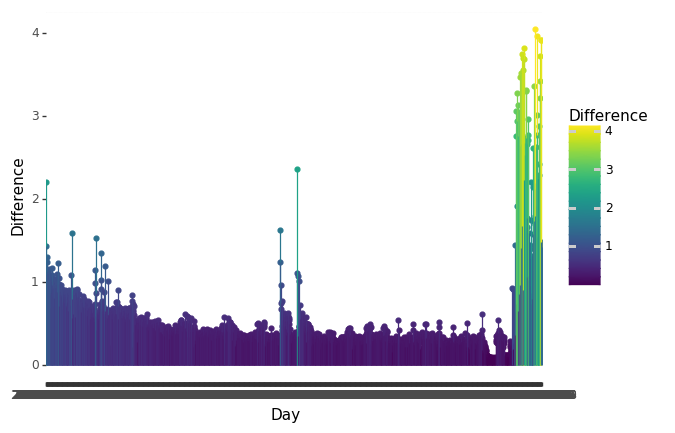

<ggplot: (8733901246356)>

In [64]:
all_heroes_differences_plot = (
    ggplot(df_all_differences_by_day, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

all_heroes_differences_plot